In [ ]:
!pip install vit_keras

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout, Activation, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import cifar10
!pip install tensorflow-addons
from vit_keras import vit, utils
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import gc

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
(train_data, train_label), (test_data, test_label) = cifar10.load_data()
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)
train_data = (train_data/255.).astype("float32")
test_data = (test_data/255.).astype("float32")

170498071/170498071 [==============================] - 13s 0us/step


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_label, random_state=seed, shuffle=True)

In [10]:
batch_size = 32
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

In [11]:
input_shape = (32, 32, 3) #Cifar10 image size
image_size = 256 #size after resizing image
num_classes = 10

def build_model():
    inputs = Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (image_size, image_size)))(inputs) #Resize image to  size 224x224
    base_model = vit.vit_b16(image_size=image_size, activation="sigmoid", pretrained=True,
                            include_top=False, pretrained_top=False)
    
    base_model.trainable = False #Set false for transfer learning
    x = base_model(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation=tfa.activations.gelu)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model_final = Model(inputs=inputs, outputs=outputs)
    return model_final

In [12]:
model = build_model()
model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
print("\n")
model.fit(train_generator,
          steps_per_epoch=200,
          epochs=2,
          validation_data=(X_valid, y_valid),)
gc.collect()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                24608     
                                                           

764

In [13]:
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

#Switch ViT layer to trainable for fine tuning
for layer in model.layers:
    layer.trainable = True
    
#Requires compile again to activate trainable=True
model.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
print("\n")
history = model.fit(train_generator,
                    steps_per_epoch=200, #you can delete this parameter to achieve more accuracy, but takes much time.
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[plateau, earlystopping]
                   )
print("\nTest Accuracy: ", accuracy_score(np.argmax(test_label, axis=1), np.argmax(model.predict(test_data), axis=1)))


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                24608     
                                                           

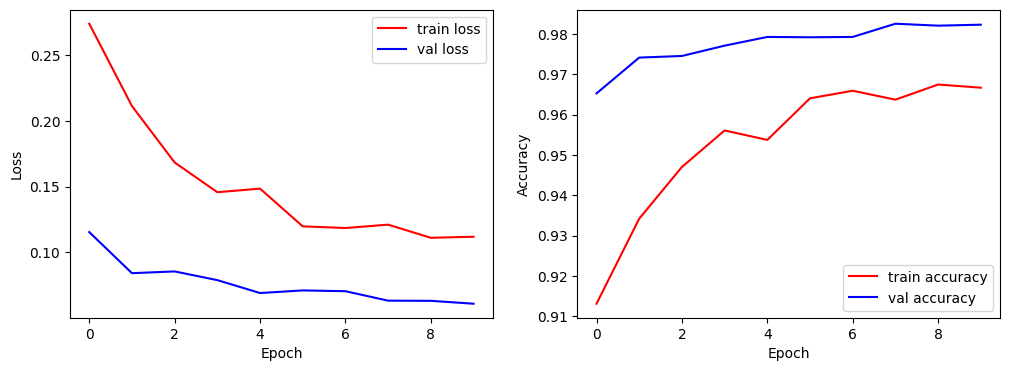

In [17]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
ax[0].plot(history.history["loss"], c="r", label="train loss")
ax[0].plot(history.history["val_loss"], c="b", label="val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], c="r", label="train accuracy")
ax[1].plot(history.history["val_accuracy"], c="b", label="val accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

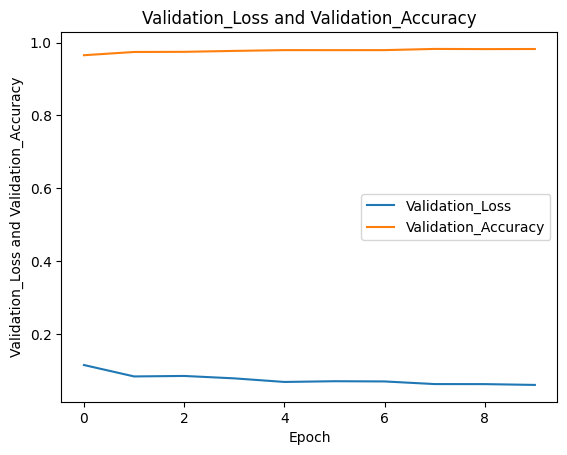

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'],label='Validation_Loss')
plt.plot(history.history['val_accuracy'], label='Validation_Accuracy' )
plt.title('Validation_Loss and Validation_Accuracy')
plt.ylabel('Validation_Loss and Validation_Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()